### Import



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import missingno as mno
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.io as pio
from wordcloud import WordCloud
from ast import main

color_pal = sns.color_palette()
plt.style.use('seaborn-dark-palette')
plt.style.use('dark_background')

import nltk

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
sns.set_theme(style='darkgrid', palette='colorblind')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

<ipython-input-1-e9e89c7629b6>:15: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Lettura dataset e ETL

In [3]:
# Lettura dati riguardanti l'oro
# Consideriamo soltanto i dati compresi tra 21-08-2017 e il 21-08-2020
gold = pd.read_csv('/content/drive/MyDrive/gold/gold-price-last-ten-years.csv', sep=',', header=8)
gold['date']=pd.to_datetime(gold['date'])
focus = (gold['date'] > '2017-08-21') & (gold['date'] <= '2020-08-21')
maindf = gold.loc[focus]
maindf.columns = ['Date', 'GLD']

In [4]:
# Lettura dati riguardanti S&P500
SP500=pd.read_csv('/content/drive/MyDrive/gold/SP500 2007-2020.csv', sep=',', header=7)
SP500['date'] = pd.to_datetime(SP500['date'])
SP500.columns = ['Date', 'SPX']
maindf=maindf.merge(SP500, how='left', on='Date')

In [5]:
# Lettura dati riguardanti Barrick
barrick = pd.read_csv('/content/drive/MyDrive/gold/Barrick Gold Corp 1985-2020.csv', sep=',', header=9)
barrick['date'] = pd.to_datetime(barrick['date'])
barrick = barrick[['date', 'close']]
barrick.columns = ['Date','BARR']
maindf = maindf.merge(barrick, how='left', on='Date')

In [6]:
# Lettura dati riguardant l'argento
silver = pd.read_csv('/content/drive/MyDrive/gold/silver history.csv', sep=',', header=7)
silver['date']=pd.to_datetime(silver['date'])
silver.columns = ['Date', 'SLV']
maindf = maindf.merge(silver, how='left', on='Date')

In [7]:
maindf.head()

,Date,GLD,SPX,BARR,SLV
0,2017-08-22,1291.0,2452.51,16.5072,17.060
1,2017-08-23,1294.7,2444.04,16.6639,17.126
2,2017-08-24,1292.0,2438.97,16.6932,17.046
3,2017-08-25,1297.9,2443.05,16.7814,17.132
4,2017-08-28,1315.3,2444.24,17.3003,17.529


In [8]:
# Check prima di assegnare "Date" come indice
maindf['Date'].value_counts().head()

Date
2017-08-22    1
2019-08-28    1
2019-08-14    1
2019-08-15    1
2019-08-16    1
Name: count, dtype: int64

In [9]:
# Setto "Date" come indice
maindf= maindf.set_index('Date')
maindf.head()

,GLD,SPX,BARR,SLV
Date,,,,
2017-08-22,1291.0,2452.51,16.5072,17.060
2017-08-23,1294.7,2444.04,16.6639,17.126
2017-08-24,1292.0,2438.97,16.6932,17.046
2017-08-25,1297.9,2443.05,16.7814,17.132
2017-08-28,1315.3,2444.24,17.3003,17.529


In [10]:
# Verifica della presenza di valori null nel dataframe
maindf.isnull().sum()

GLD      0
SPX     16
BARR    16
SLV     11
dtype: int64

In [11]:
maindf.describe()


,GLD,SPX,BARR,SLV
count,759.000000,743.000000,743.000000,748.000000
mean,1405.848419,2846.261023,16.046517,16.575697
std,186.315921,226.333878,4.703624,2.132119
min,1176.700000,2237.400000,9.666000,11.772000
25%,1281.300000,2688.700000,12.871200,15.242500
50%,1324.950000,2821.930000,14.123100,16.463300
75%,1503.750000,2978.735000,17.760450,17.279250
max,2061.500000,3397.160000,30.130000,29.261000


In [12]:
maindf = maindf.fillna(axis=0, method='ffill')
maindf.describe()

,GLD,SPX,BARR,SLV
count,759.000000,759.000000,759.000000,759.000000
mean,1405.848419,2846.759908,16.037577,16.573859
std,186.315921,227.016344,4.687174,2.123482
min,1176.700000,2237.400000,9.666000,11.772000
25%,1281.300000,2688.700000,12.882800,15.244900
50%,1324.950000,2820.400000,14.123100,16.460600
75%,1503.750000,2979.075000,17.760900,17.282500
max,2061.500000,3397.160000,30.130000,29.261000


In [13]:
maindf.isnull().sum()

GLD     0
SPX     0
BARR    0
SLV     0
dtype: int64

Rimpiazzando i valori null con ffill, non cambiano le caratteristiche del dataset, come media e deviazione standard.

### EDA

Text(0, 0.5, 'Value')

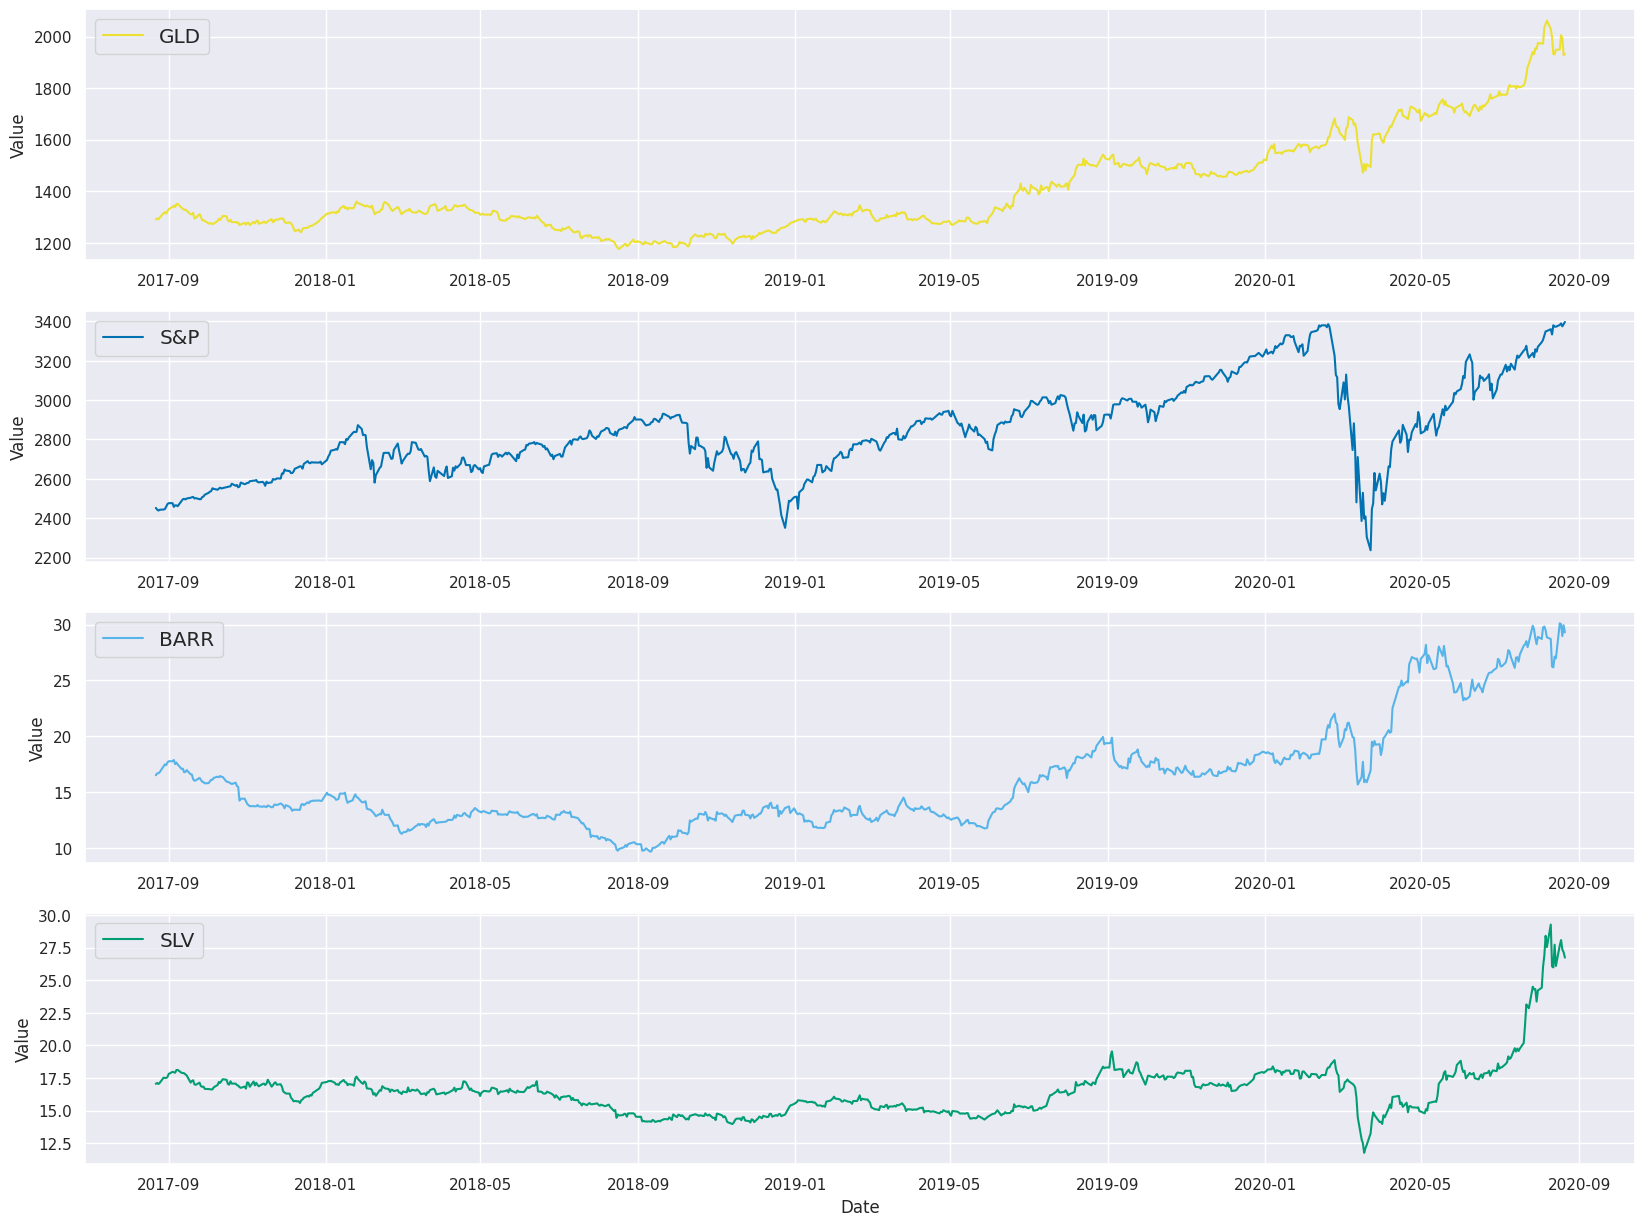

In [14]:
# Plot degli andamenti tmeporali dei costi
plt.figure(figsize=(20,15))
plt.subplot(411)
plt.plot(maindf['GLD'], label='GLD', color='y')
plt.legend(loc='best', fontsize='large')
plt.ylabel('Value')
plt.subplot(412)
plt.plot(maindf['SPX'], label='S&P', color='b')
plt.legend(loc='best', fontsize='large')
plt.ylabel('Value')
plt.subplot(413)
plt.plot(maindf['BARR'], label='BARR', color='c')
plt.legend(loc='best', fontsize='large')
plt.ylabel('Value')
plt.subplot(414)
plt.plot(maindf['SLV'], label='SLV', color='g')
plt.legend(loc='best', fontsize='large')
plt.xlabel('Date')
plt.ylabel('Value')

In [15]:
maindf.shape

(759, 4)

### Forecasting GOLD con ARIMA

 Decisione parametri modello **ARIMA**

In [16]:
# Abbiamo 759 dati. Ne utilizziamo 100 per il test e il resto per il train.
test_dim = 59
df_train, df_test = maindf[0:-test_dim], maindf[-test_dim:]
print(df_train.shape, df_test.shape)

(700, 4) (59, 4)


In [17]:
# Cerchiamo il p-value
adf_result_gold = adfuller(df_train['GLD'])

print('ADF Statistic:', adf_result_gold[0])
print('p-value:', adf_result_gold[1])
print('Valori critici:', adf_result_gold[4])

ADF Statistic: 0.9366201288836085
p-value: 0.9935500941892942
Valori critici: {'1%': -3.439960610754265, '5%': -2.8657809735786244, '10%': -2.5690284373908066}


Il p-value risulta essere maggiore di 0.05, dunque la serie è considerata non stazionaria. Bisogna differenziare i dati al fine di rendere la serie stazionaria.

In [18]:
# Differenziamo il train set
df_train_diff = df_train.diff().dropna()

In [19]:
# Cerchiamo il p-value
adf_result_gold = adfuller(df_train_diff['GLD'])

print('ADF Statistic:', adf_result_gold[0])
print('p-value:', adf_result_gold[1])
print('Valori critici:', adf_result_gold[4])

ADF Statistic: -6.82423147461058
p-value: 1.9664637338833836e-09
Valori critici: {'1%': -3.439960610754265, '5%': -2.8657809735786244, '10%': -2.5690284373908066}


Il p-value risulta essere minore di 0.05, dunque la serie ora è stazionaria. Il parametro d del modello arima dunque sarà 1, ossia il numero di differenziazioni necessarie a rendere la serie stazionaria.

Stampiamo i grafici di autocorrelazione e autocorrelazione parziale per cercare i parametri p e q: il primo si ricava contando il numero di valori al di fuori del limite di significatività nel grafico di autocorrelazione, il secondo nel grafico di autocorrelazione parziale.

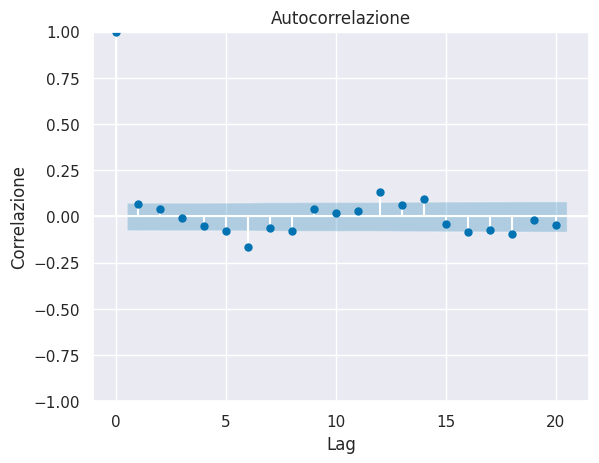

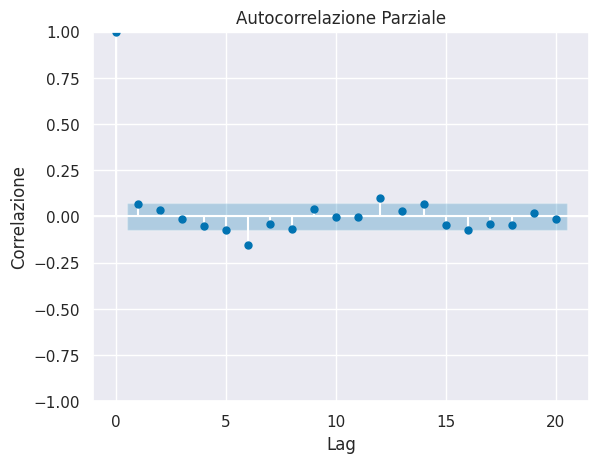

In [20]:
plot_acf(df_train_diff['GLD'], lags=20)
plt.title('Autocorrelazione')
plt.xlabel('Lag')
plt.ylabel('Correlazione')
plt.show()

# Calcola e plotta la PACF del numero di terremoti mensili
plot_pacf(df_train_diff['GLD'], lags=20)
plt.title('Autocorrelazione Parziale')
plt.xlabel('Lag')
plt.ylabel('Correlazione')
plt.show()

Dai grafici poniamo p=4 e q=2.

Nella cella di seguito utilizziamo auto_arima per farci restituire i parametri ottimali e verificare che quelli scelti siano effettivamente i migliori.

In [21]:
model = auto_arima(df_train['GLD'], seasonal=False, suppress_warnings=True)

print("Migliori parametri p, d e q:", model.order)

Migliori parametri p, d e q: (2, 1, 2)


Notiamo che i parametri p, d e q calcolati da noi e restituiti da auto_arima sono diversi.
Facciamo due prove per vedere quale è effettivamente il migliore. Risulta possibile che i valori di p e q identificati tramite l'analisi dei grafici di autocorrelazione e autocorrelazione parziale siano diversi da quelli ottenuti utilizzando la funzione auto_arima o altri metodi automatizzati di selezione del modello, poichè l'analisi visiva dei grafici può fornire solo indicazioni approssimative sui valori ottimali di p e q, mentre i metodi automatizzati utilizzano algoritmi più sofisticati per trovare il modello migliore in base a criteri statistici come AIC o BIC.
Ciò che facciamo, dunque, è testare entrambe le terne di parametri.

**Parametri ricavati da noi (4,1,2)**

In [22]:
model_arima = ARIMA(endog = df_train['GLD'], order=(4,1,2)).fit()
predictions = model_arima.forecast(steps= test_dim)

In [23]:
RMSE = (mean_squared_error(df_test['GLD'].values, predictions))**0.5
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 150.937


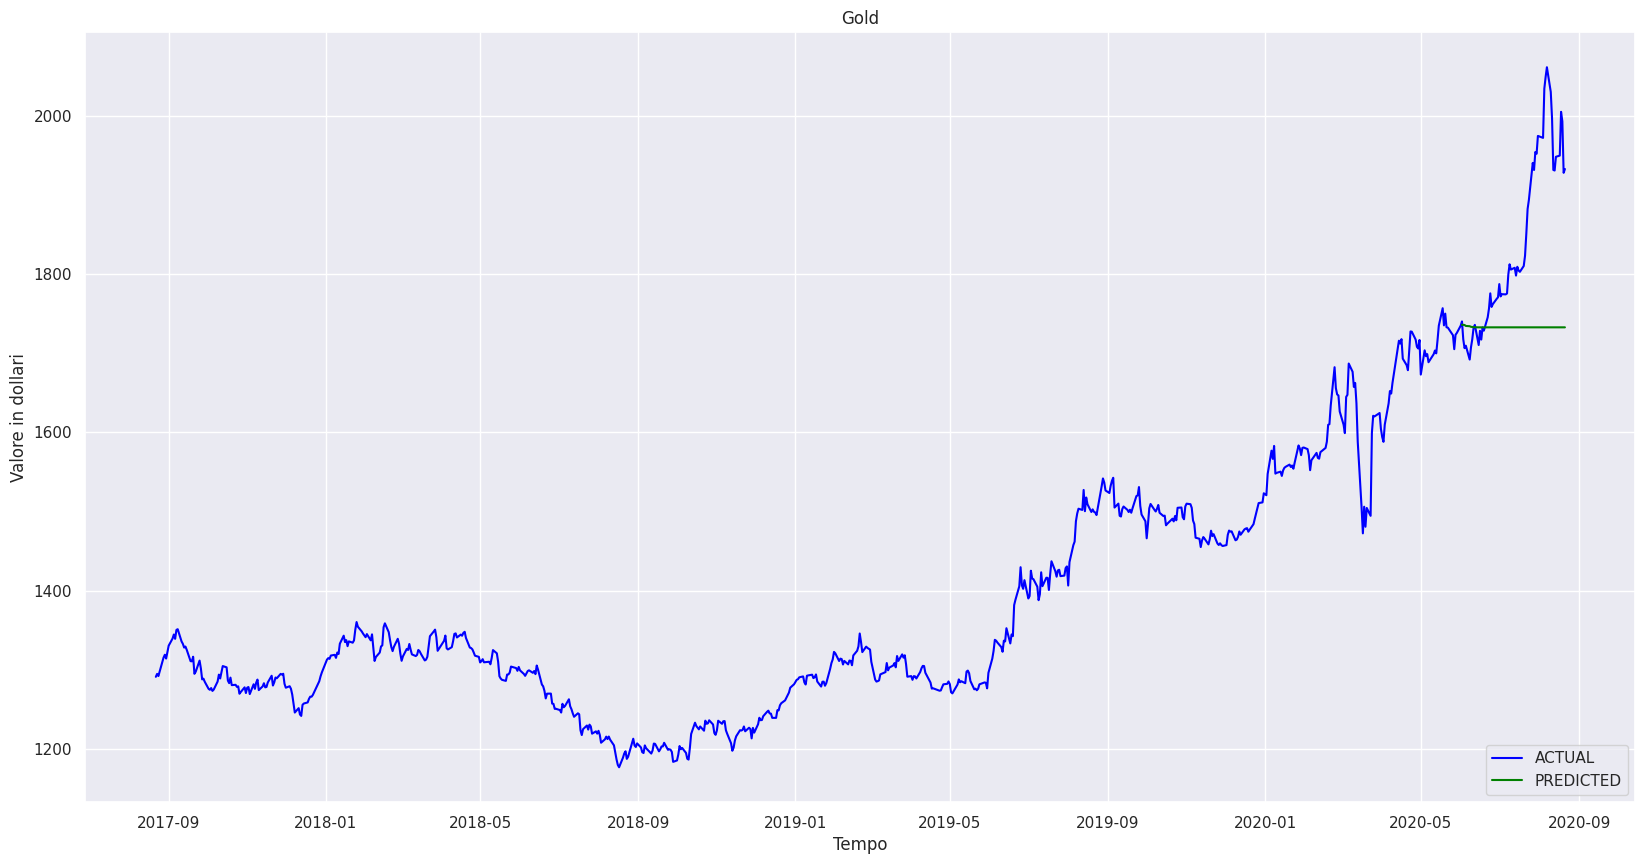

In [26]:
# plot
plt.title('Gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(maindf.index, maindf['GLD'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

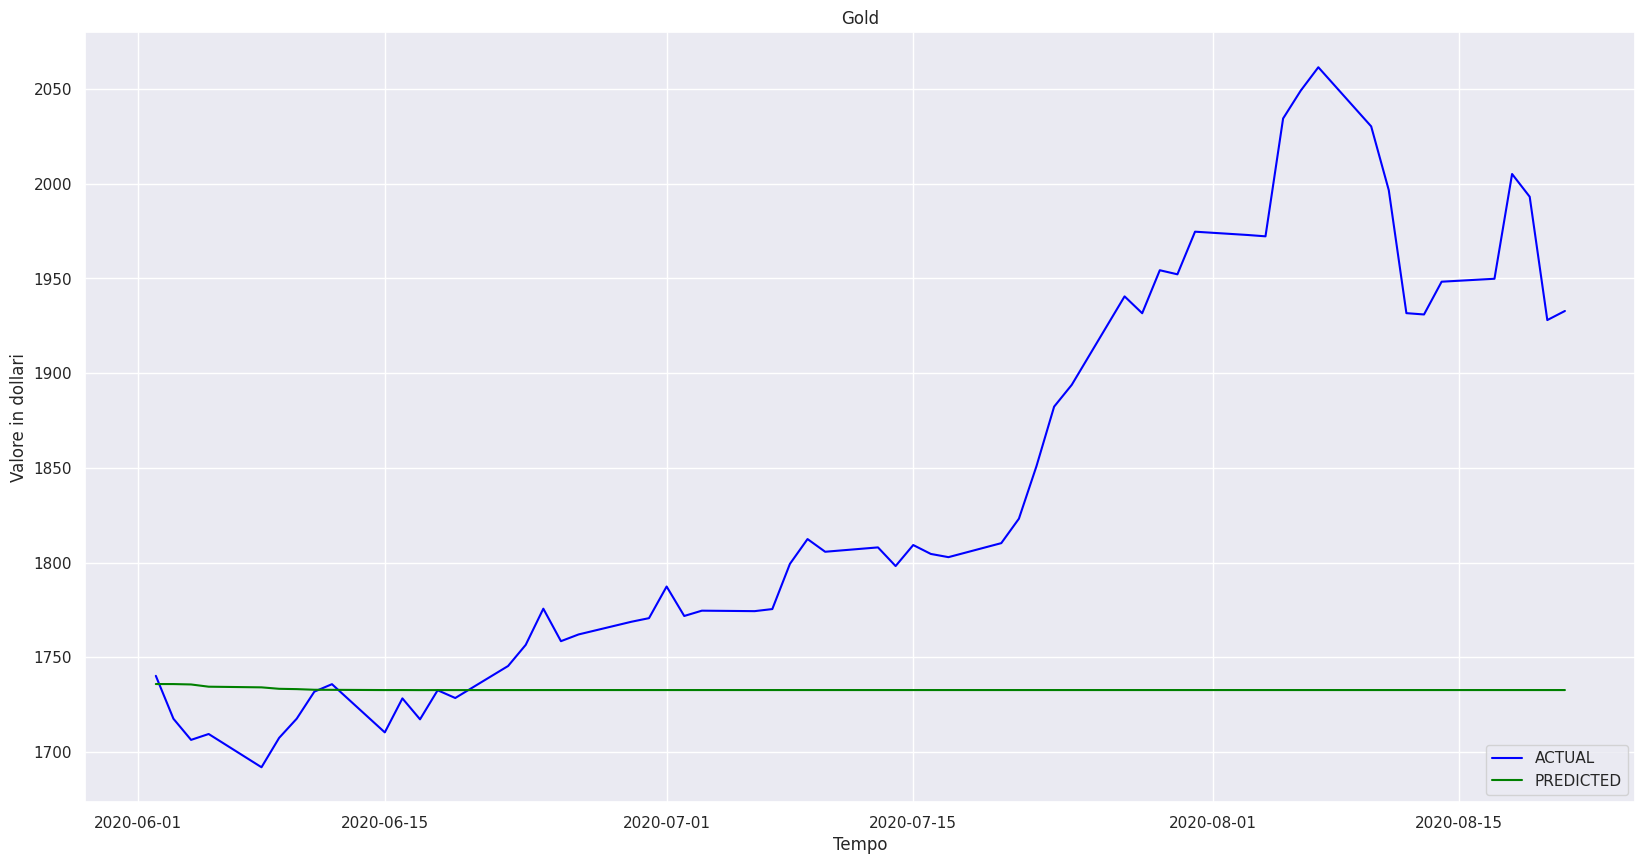

In [25]:
# plot
plt.title('Gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(df_test.index, df_test['GLD'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

**Parametri ricavati da auto_arima**

In [27]:
model_arima = ARIMA(endog = df_train['GLD'], order=(2,1,2)).fit()
predictions = model_arima.forecast(steps= test_dim)

In [28]:
RMSE = (mean_squared_error(df_test['GLD'].values, predictions))**0.5
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 149.535


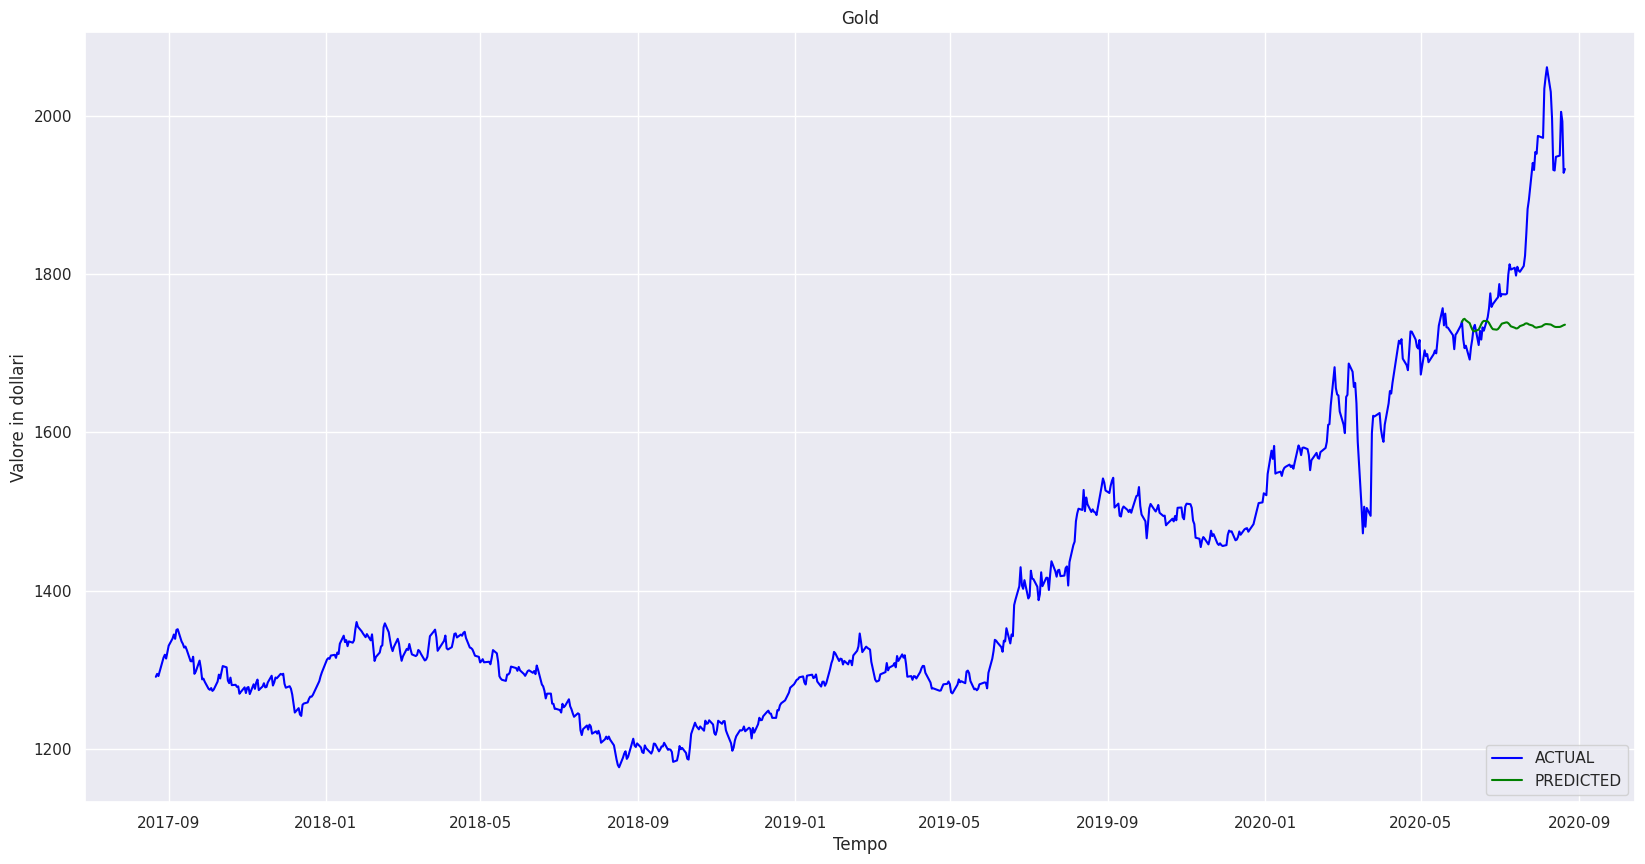

In [29]:
# plot
plt.title('Gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(maindf.index, maindf['GLD'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

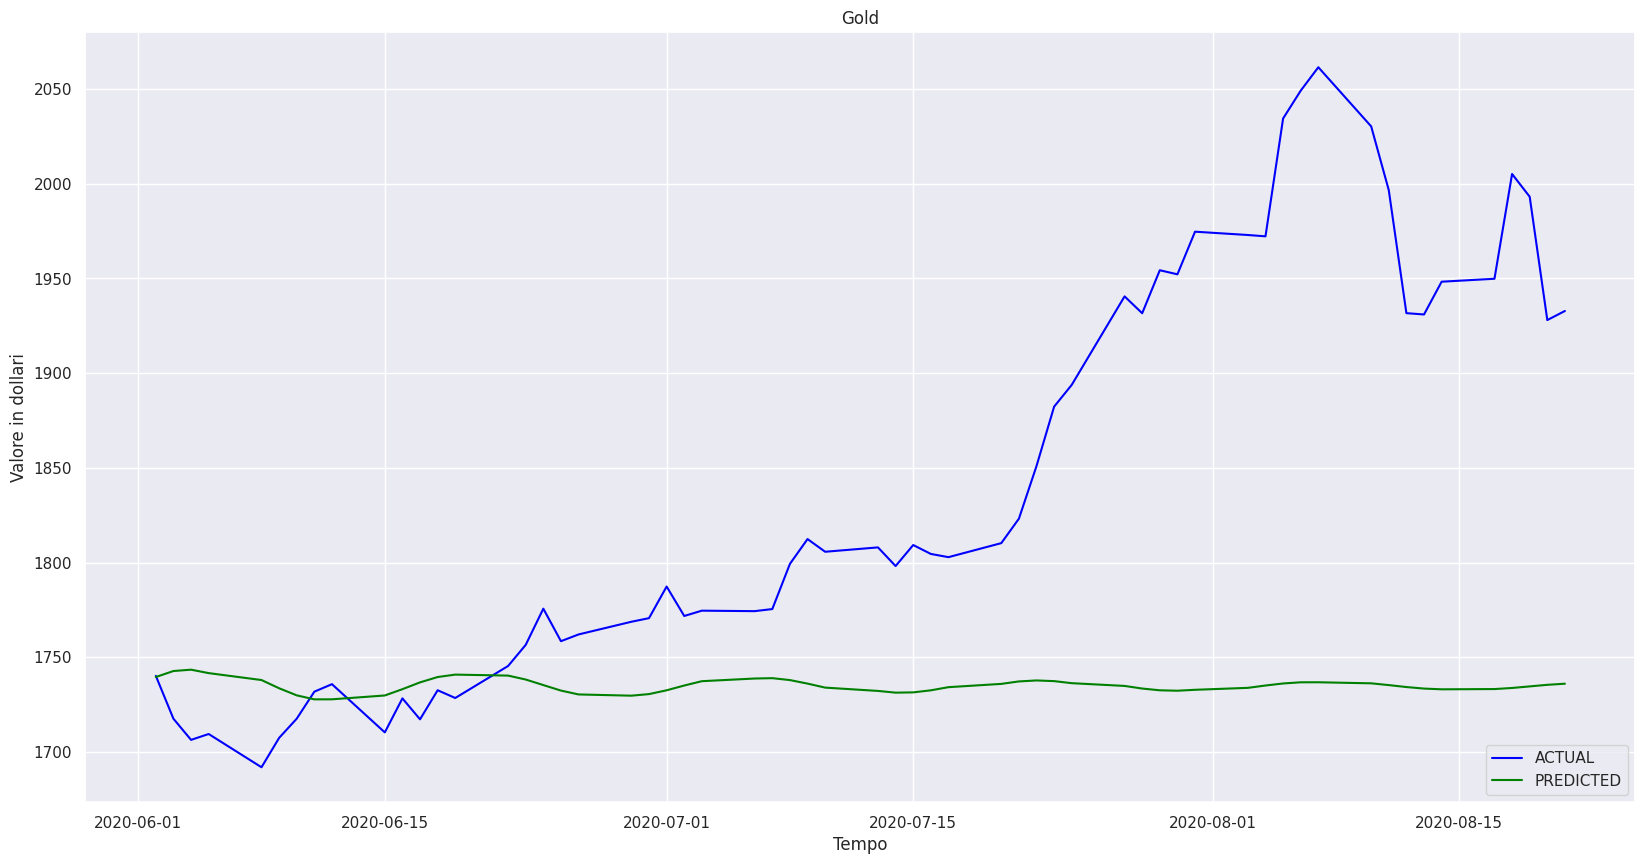

In [30]:
# plot
plt.title('Gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(df_test.index, df_test['GLD'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

Notiamo che il modello ARIMA non riesce a predirre bene il prezzo dell'oro, nonostante l'utilizzo dei parametri ottimali, che erano quelli restituiti da auto_arima, come si poteva intuire.

Dunque, cambiamo strategia e utilizziamo il modello SARIMAX per poter inserire nel modello anche le variabili esogene (SLV, BARR e SPX).

### Forecasting GOLD con SARIMAX (SLV, BARR e SPX variabili esogene)

Per definire i parametri ottimali (p, d e q, come nel caso del modello ARIMA) potremmo utilizzare di nuovo la funzione auto_arima, la quale, però, non tiene conto delle variabili esogene.
Dunque, utilizziamo una Grid Search per ricavare la combinazione di parametri ottimali.

In [32]:
# Grid Search per vedere quali sono i parametri ottimali
p_values = [0, 1, 2, 3, 4, 5, 6, 7]
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5, 6, 7]

# Variabili endogene
endog_train = df_train['GLD'].values
endog_test = df_test['GLD'].values

# Variabili esogene
exog_train = df_train[['BARR', 'SLV', 'SPX']].values
exog_test = df_test[['BARR', 'SLV', 'SPX']].values

best_RMSE = np.inf
best_params = None

# Ricerca a griglia dei parametri ottimali
for p, d, q in product(p_values, d_values, q_values):
    try:
        model = SARIMAX(endog=endog_train, exog=exog_train, order=(p, d, q))
        fit_model = model.fit()
        predictions = fit_model.forecast(steps=len(endog_test), exog=exog_test)
        RMSE = (mean_squared_error(endog_test, predictions))**0.5

        # Aggiornamento dei parametri ottimali se l'errore attuale è minore del migliore errore
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_params = (p, d, q)

    except:
        continue

print("Parametri ottimali:", best_params)
print("Root Mean Squared Error:", best_RMSE)


Parametri ottimali: (2, 1, 6)
Root Mean Squared Error: 33.19523659461659


In [34]:
order = (2, 1, 6)
model_sarimax = SARIMAX(endog=endog_train, exog=exog_train, order=order)
fit_model = model_sarimax.fit()

predictions = fit_model.forecast(steps= test_dim, exog=exog_test)

rmse = (mean_squared_error(endog_test, predictions))**0.5
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 33.19523659461659


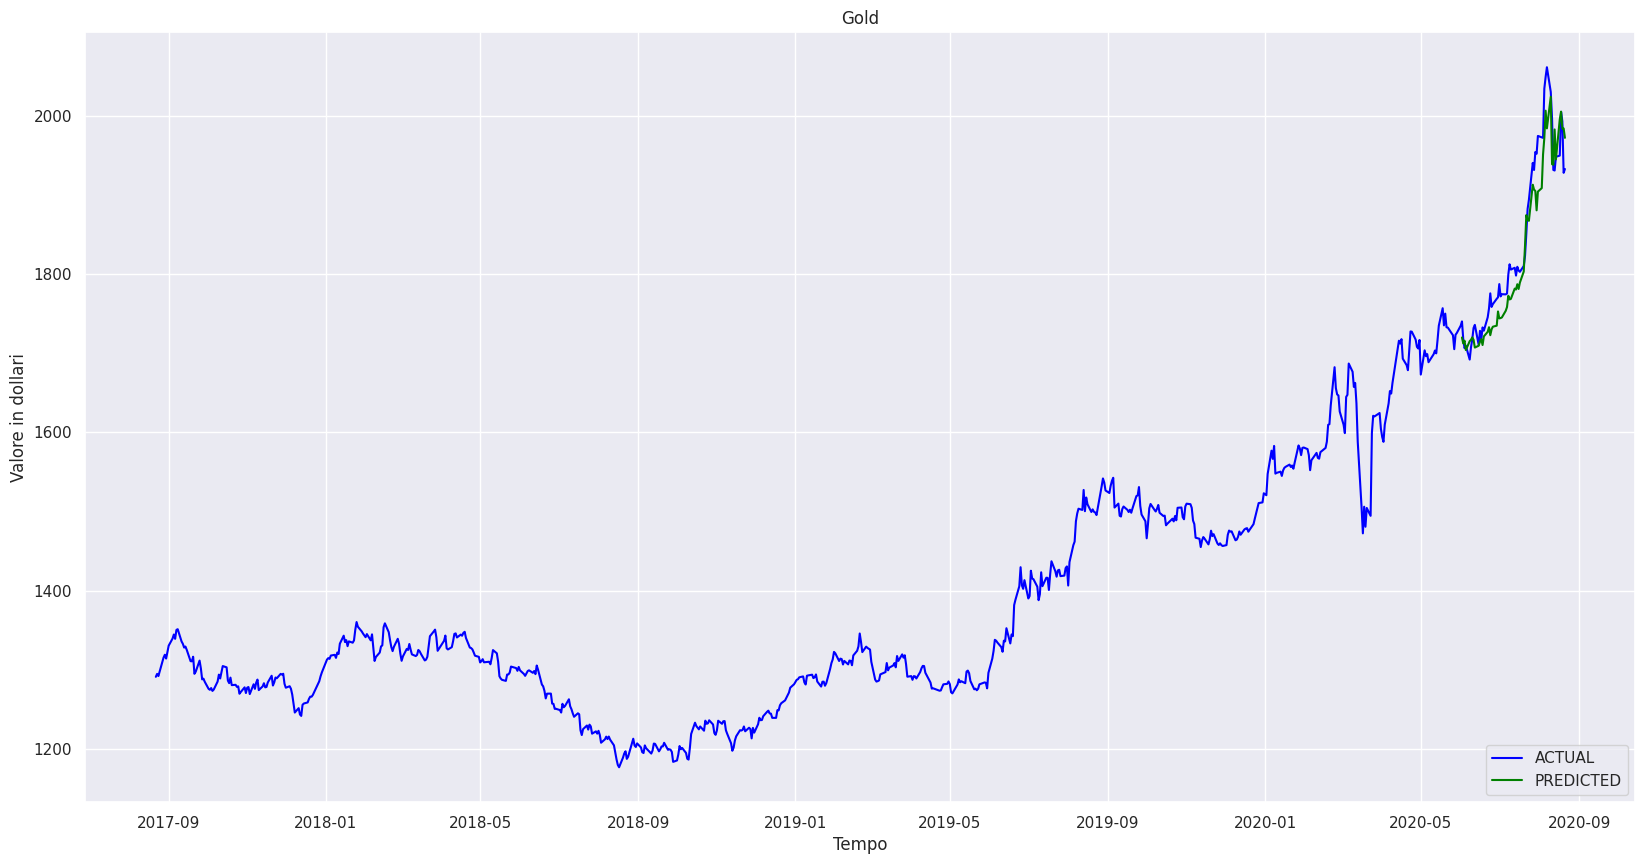

In [35]:
# plot
plt.title('Gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(maindf.index, maindf['GLD'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

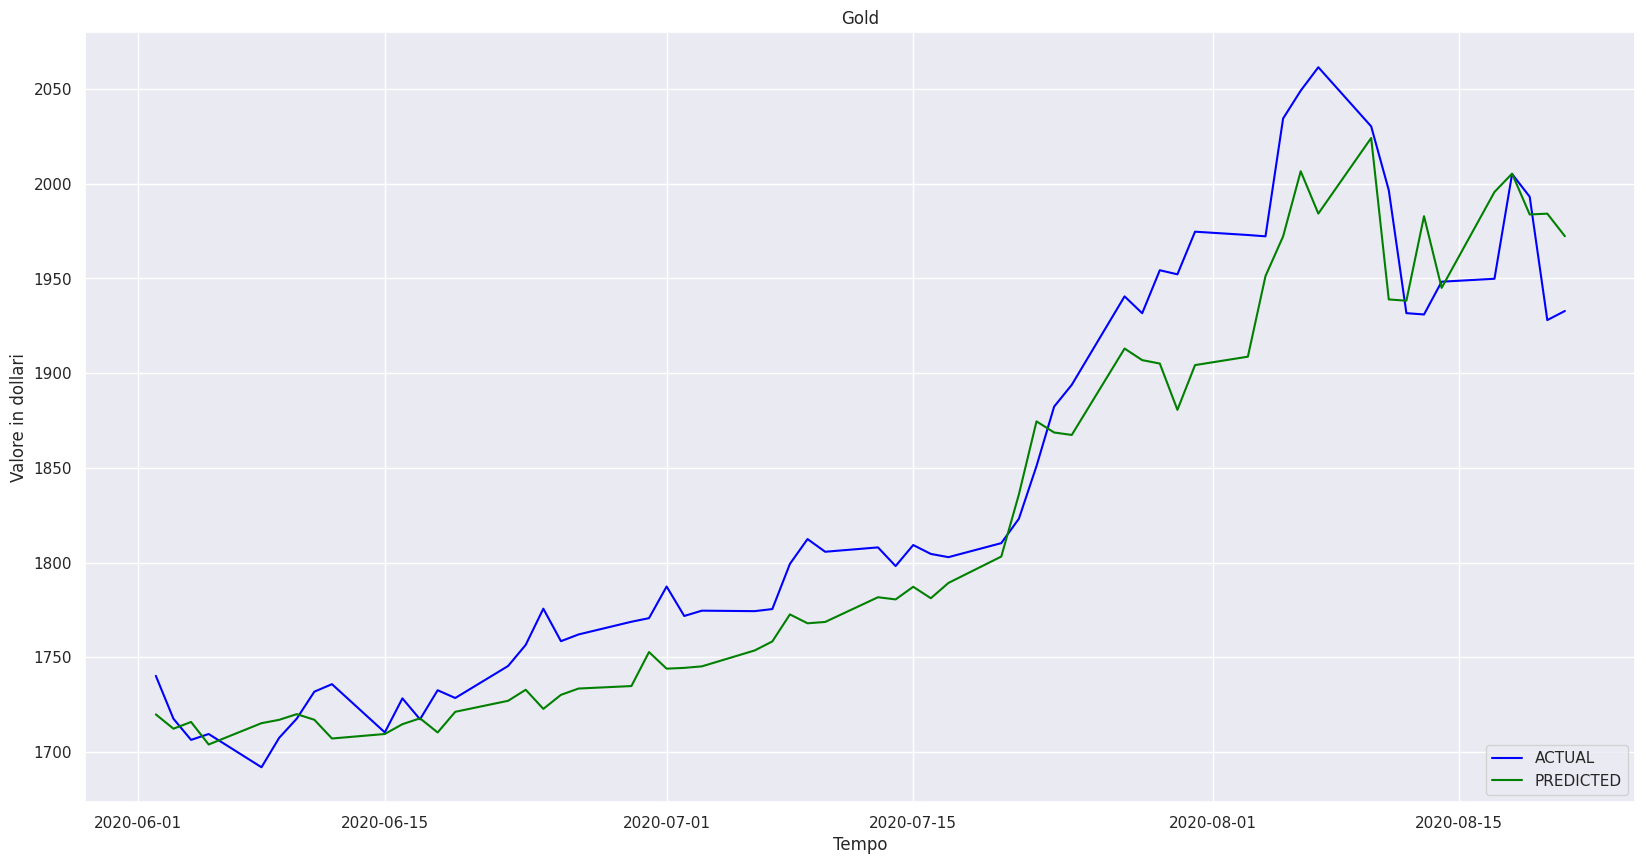

In [36]:
# plot
plt.title('Gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(df_test.index, df_test['GLD'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

### Forecasting GOLD con SARIMAX (BARR e SLV come variabili esogene)

In [62]:
# Grid Search per vedere quali sono i parametri ottimali
p_values = [0, 1, 2, 3, 4, 5, 6, 7]
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5, 6, 7]

# Variabili endogene
endog_train = df_train['GLD'].values
endog_test = df_test['GLD'].values

# Variabili esogene
exog_train = df_train[['BARR', 'SLV']].values
exog_test = df_test[['BARR', 'SLV']].values

best_RMSE = np.inf
best_params = None

# Ricerca a griglia dei parametri ottimali
for p, d, q in product(p_values, d_values, q_values):
    try:
        model = SARIMAX(endog=endog_train, exog=exog_train, order=(p, d, q))
        fit_model = model.fit()
        predictions = fit_model.forecast(steps=len(endog_test), exog=exog_test)
        RMSE = (mean_squared_error(endog_test, predictions))**0.5

        # Aggiornamento dei parametri ottimali se l'errore attuale è minore del migliore errore
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_params = (p, d, q)

    except:
        continue

print("Parametri ottimali:", best_params)
print("Root Mean Squared Error:", best_RMSE)


Parametri ottimali: (3, 1, 6)
Root Mean Squared Error: 32.25443197009848


In [19]:
order = (3, 1, 6)
model_sarimax = SARIMAX(endog=endog_train, exog=exog_train, order=order)
fit_model = model_sarimax.fit()

predictions = fit_model.forecast(steps= test_dim, exog=exog_test)

rmse = (mean_squared_error(endog_test, predictions))**0.5
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 32.25443197009848


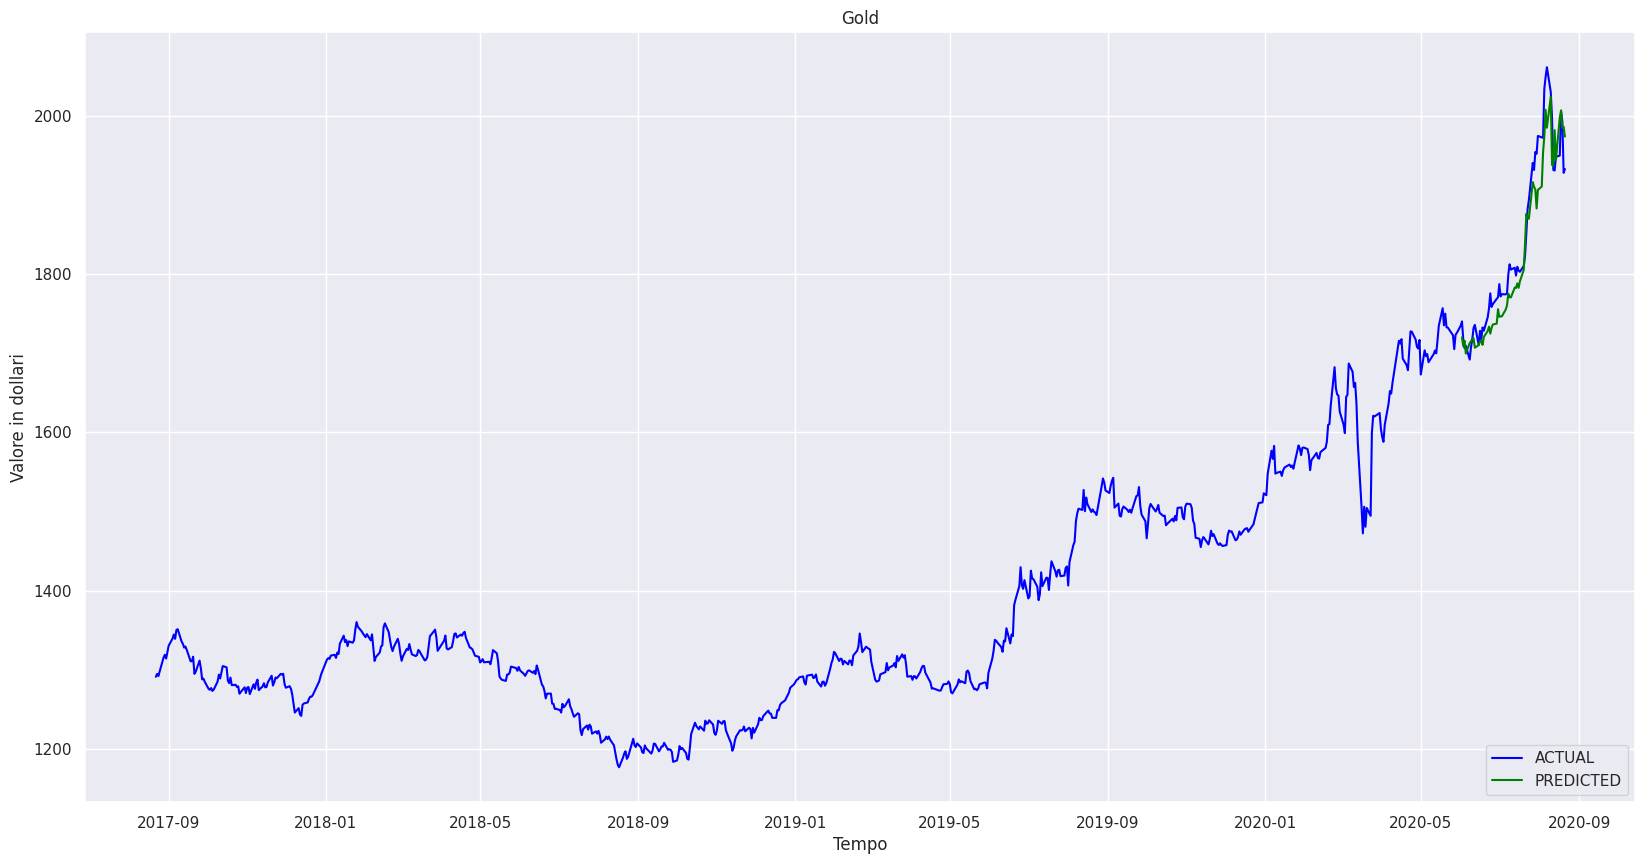

In [22]:
# plot
plt.title('Gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(maindf.index, maindf['GLD'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

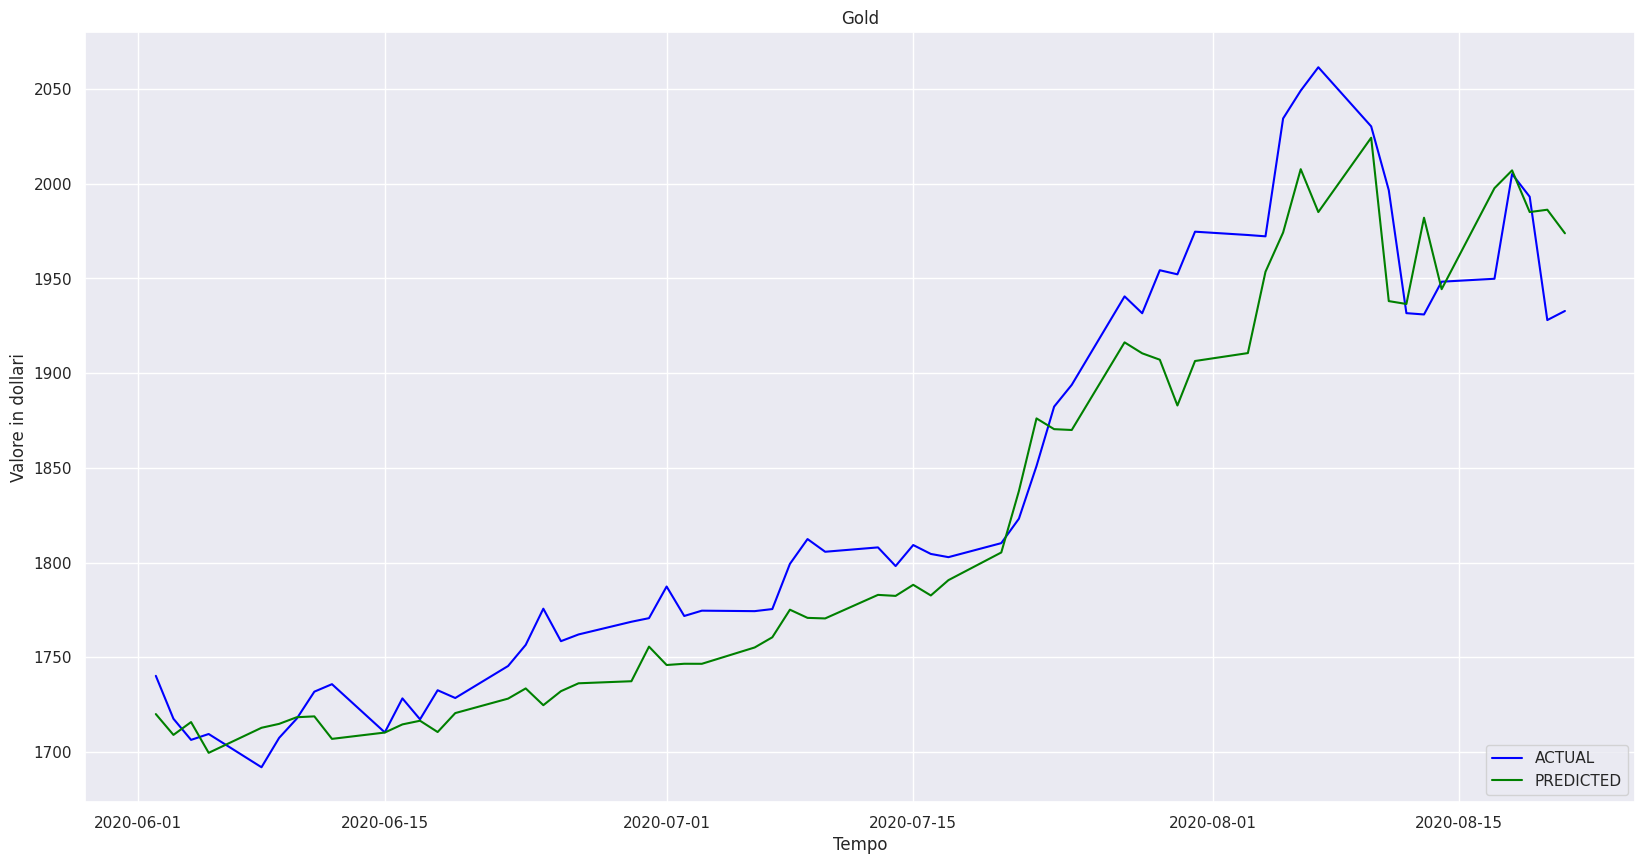

In [21]:
# plot
plt.title('Gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(df_test.index, df_test['GLD'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

### Forecasting SILVER con SARIMAX (GLD, BARR e SPX come variabili esogene)

In [37]:
# Grid Search per vedere quali sono i parametri ottimali
p_values = [0, 1, 2, 3, 4, 5, 6, 7]
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5, 6, 7]

# Variabili endogene
endog_train = df_train['SLV'].values
endog_test = df_test['SLV'].values

# Variabili esogene
exog_train = df_train[['BARR', 'GLD', 'SPX']].values
exog_test = df_test[['BARR', 'GLD', 'SPX']].values

best_RMSE = np.inf
best_params = None

# Ricerca a griglia dei parametri ottimali
for p, d, q in product(p_values, d_values, q_values):
    try:
        model = SARIMAX(endog=endog_train, exog=exog_train, order=(p, d, q))
        fit_model = model.fit()
        predictions = fit_model.forecast(steps=len(endog_test), exog=exog_test)
        RMSE = (mean_squared_error(endog_test, predictions))**0.5

        # Aggiornamento dei parametri ottimali se l'errore attuale è minore del migliore errore
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_params = (p, d, q)

    except:
        continue

print("Parametri ottimali:", best_params)
print("Root Mean Squared Error:", best_RMSE)


Parametri ottimali: (7, 1, 5)
Root Mean Squared Error: 2.230976762800621


In [38]:
order = (7, 1, 5)
model_sarimax = SARIMAX(endog=endog_train, exog=exog_train, order=order)
fit_model = model_sarimax.fit()

predictions = fit_model.forecast(steps= test_dim, exog=exog_test)

rmse = (mean_squared_error(endog_test, predictions))**0.5
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 2.230976762800621


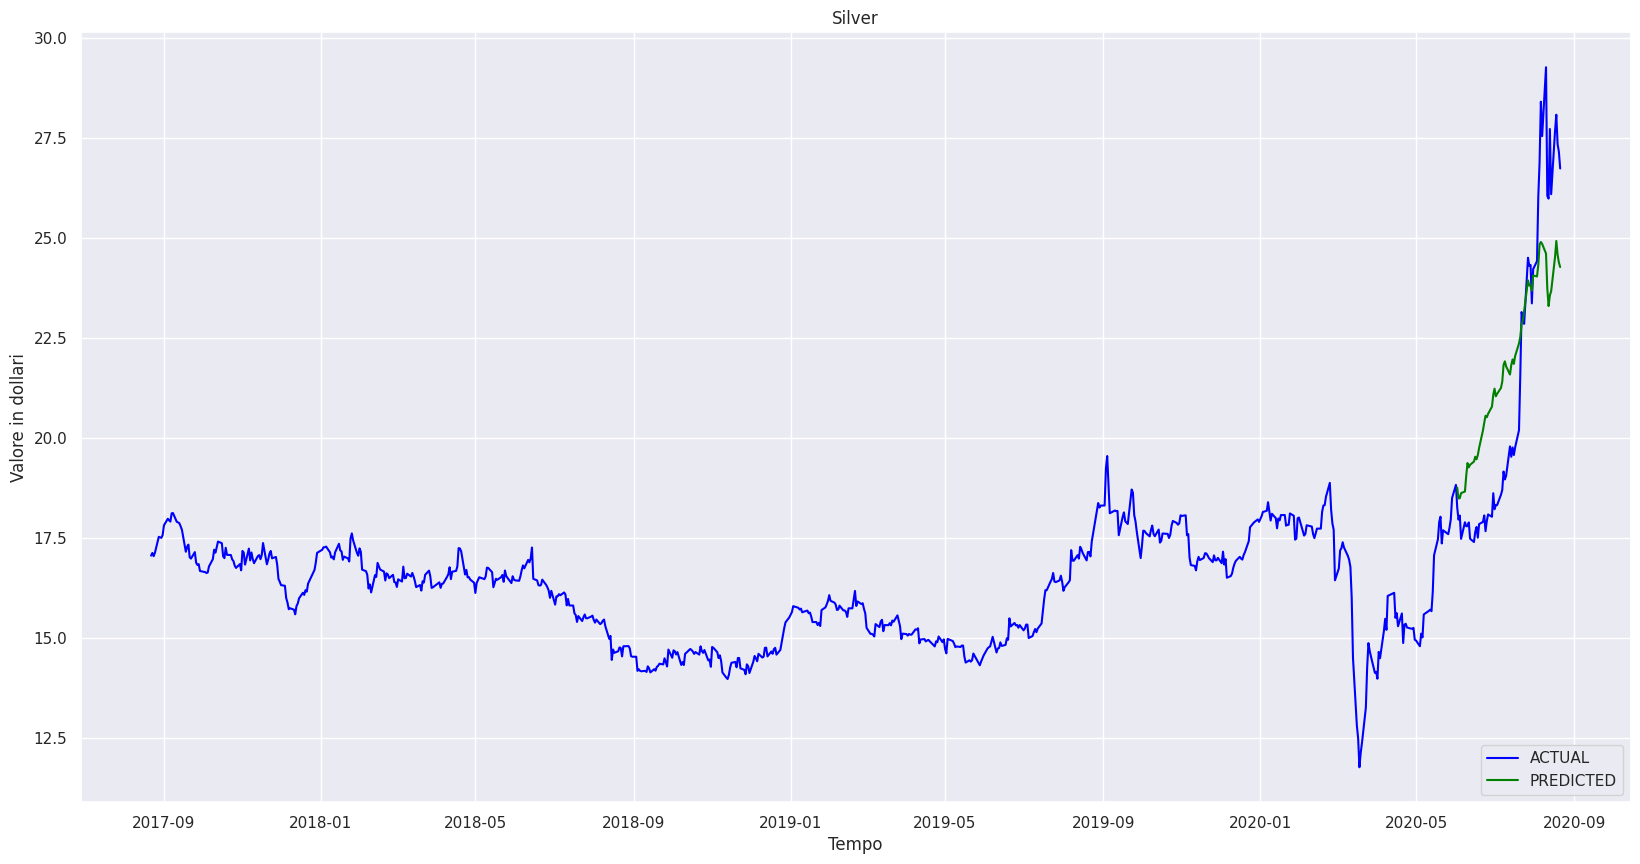

In [39]:
# plot
plt.title('Silver')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(maindf.index, maindf['SLV'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

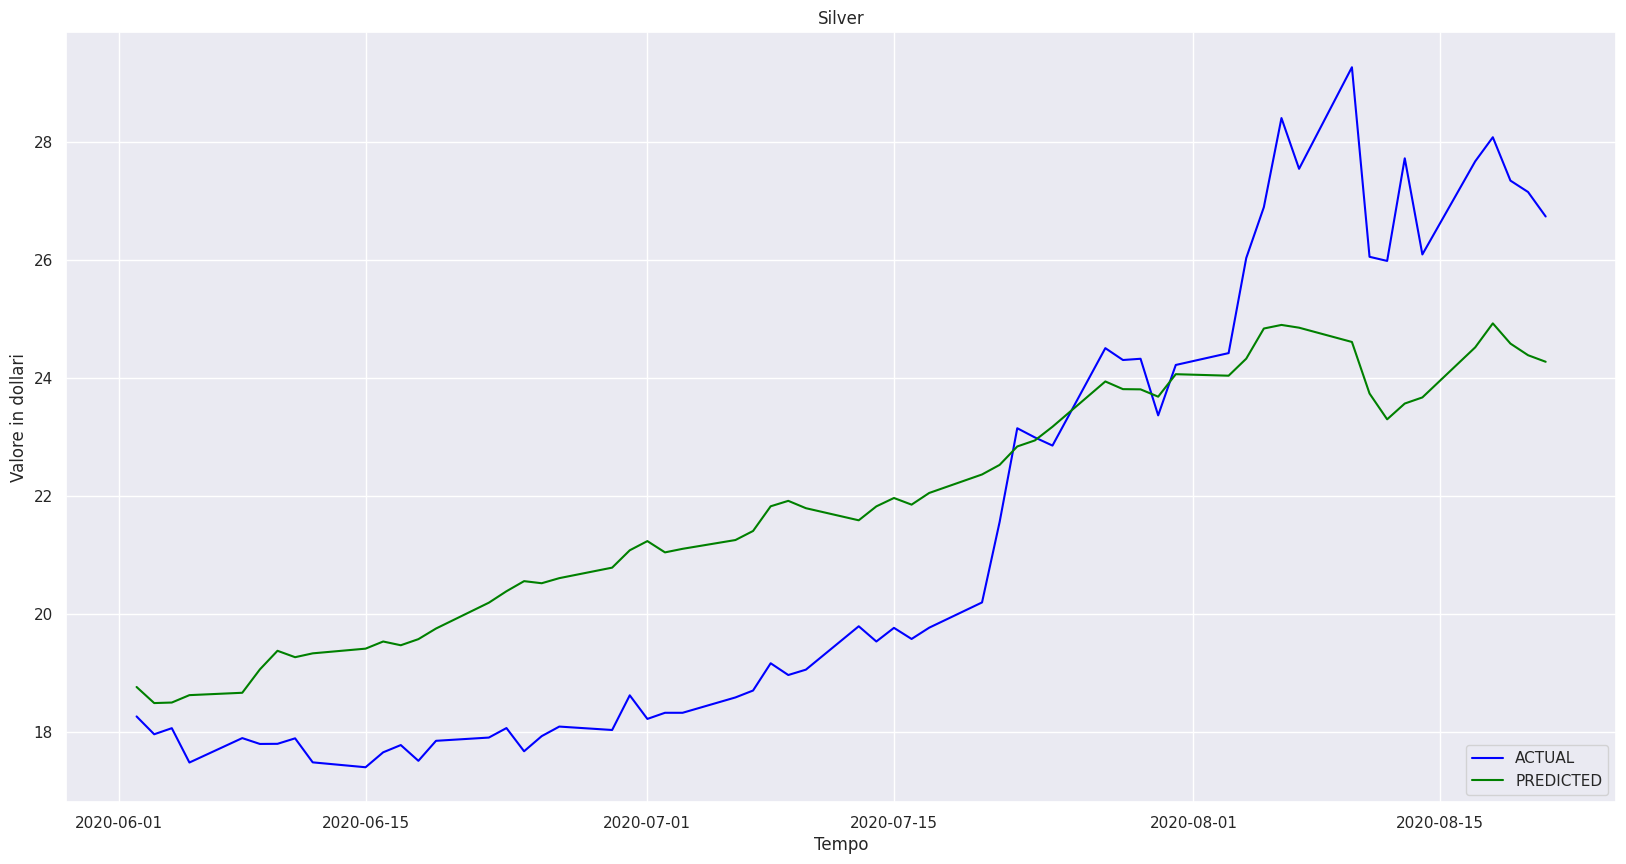

In [40]:
# plot
plt.title('Silver')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(df_test.index, df_test['SLV'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

### Forecasting BARRICK con SARIMAX (GLD, SLV e SPX come variabili esogene)

In [41]:
# Grid Search per vedere quali sono i parametri ottimali
p_values = [0, 1, 2, 3, 4, 5, 6, 7]
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5, 6, 7]

# Variabili endogene
endog_train = df_train['BARR'].values
endog_test = df_test['BARR'].values

# Variabili esogene
exog_train = df_train[['GLD', 'SLV', 'SPX']].values
exog_test = df_test[['GLD', 'SLV', 'SPX']].values

best_RMSE = np.inf
best_params = None

# Ricerca a griglia dei parametri ottimali
for p, d, q in product(p_values, d_values, q_values):
    try:
        model = SARIMAX(endog=endog_train, exog=exog_train, order=(p, d, q))
        fit_model = model.fit()
        predictions = fit_model.forecast(steps= test_dim, exog=exog_test)
        RMSE = (mean_squared_error(endog_test, predictions))**0.5

        # Aggiornamento dei parametri ottimali se l'errore attuale è minore del migliore errore
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_params = (p, d, q)

    except:
        continue

print("Parametri ottimali:", best_params)
print("Root Mean Squared Error:", best_RMSE)


Parametri ottimali: (2, 1, 2)
Root Mean Squared Error: 1.9204774446982456


In [42]:
order = (2, 1, 2)
model_sarimax = SARIMAX(endog=endog_train, exog=exog_train, order=order)
fit_model = model_sarimax.fit()

predictions = fit_model.forecast(steps= test_dim, exog=exog_test)

rmse = (mean_squared_error(endog_test, predictions))**0.5
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 1.9204774446982456


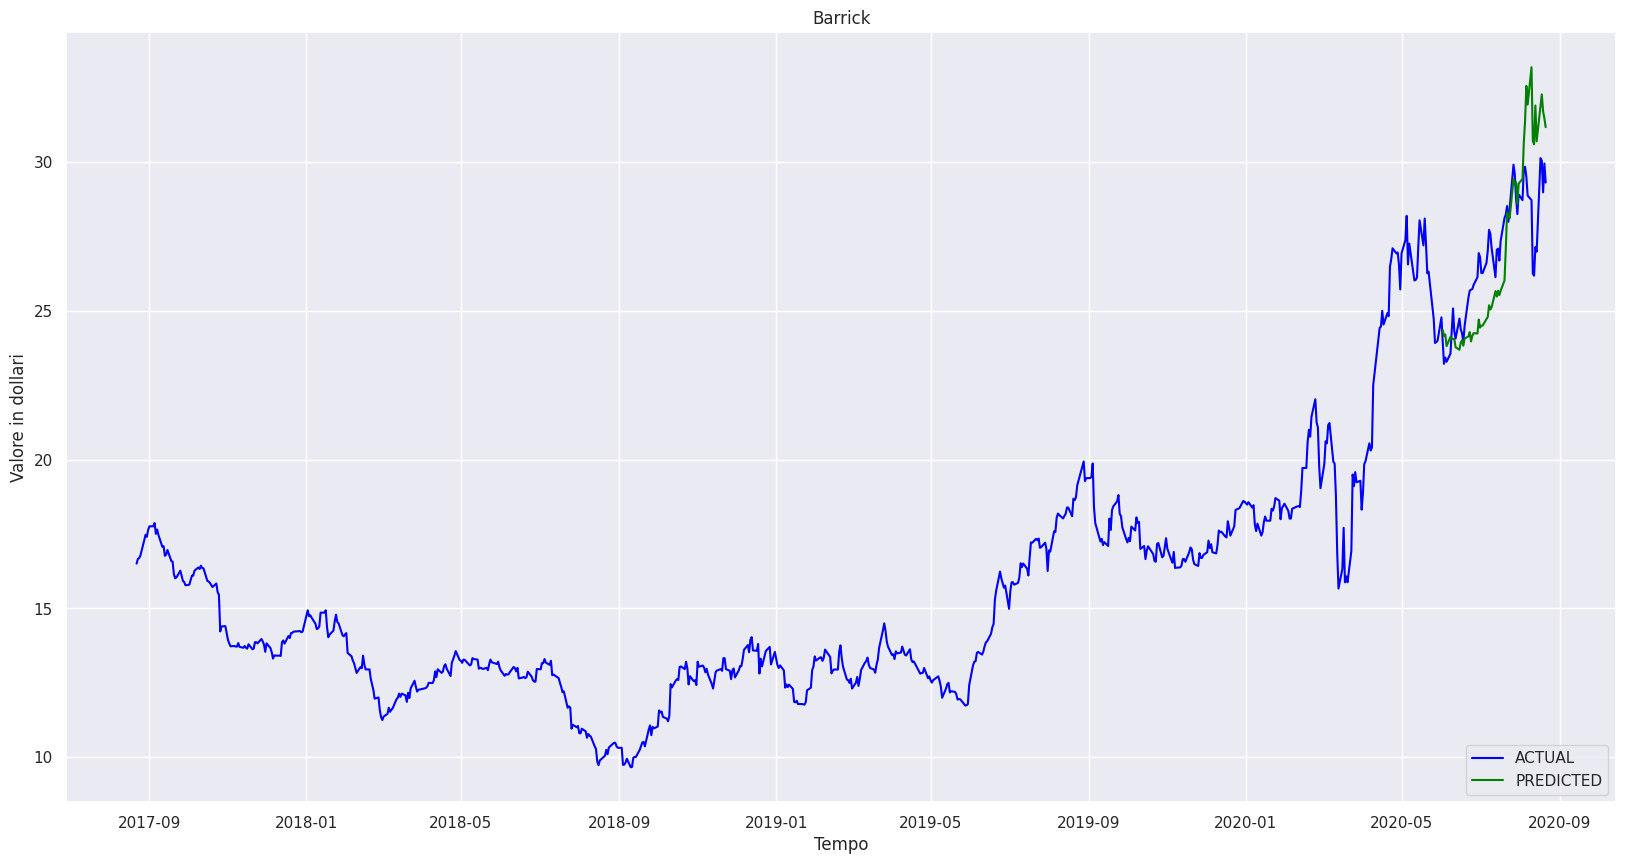

In [43]:
# plot
plt.title('Barrick')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(maindf.index, maindf['BARR'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

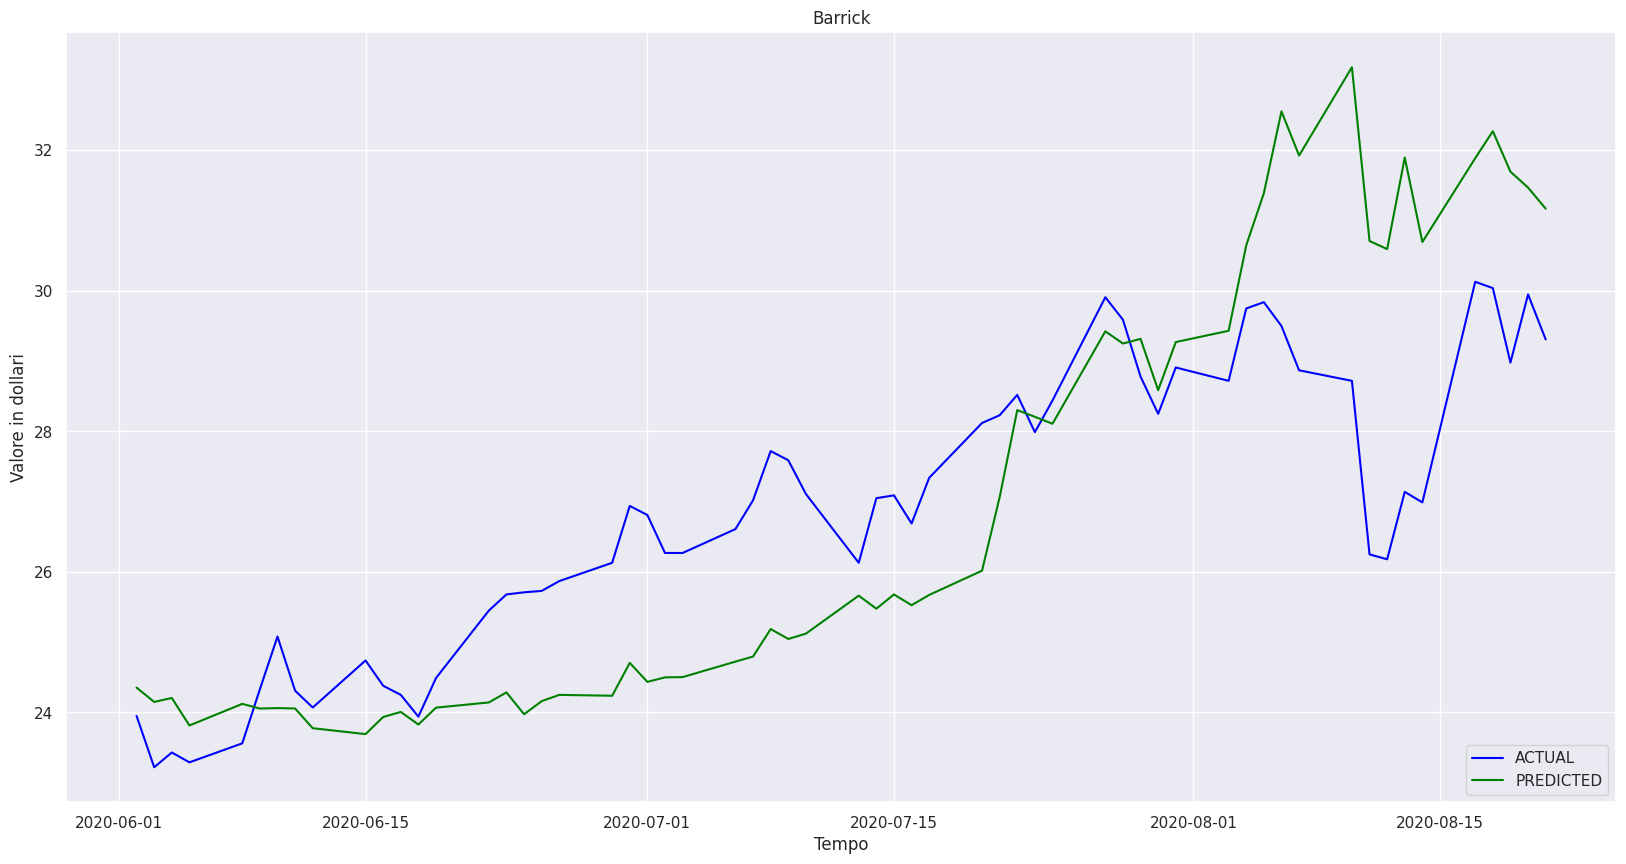

In [44]:
# plot
plt.title('Barrick')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(df_test.index, df_test['BARR'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

### Forecasting BARRICK con SARIMAX (SLV come variabile esogena)

In [53]:
# Grid Search per vedere quali sono i parametri ottimali
p_values = [0, 1, 2, 3, 4, 5, 6, 7]
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5, 6, 7]

# Variabili endogene
endog_train = df_train['BARR'].values
endog_test = df_test['BARR'].values

# Variabili esogene
exog_train = df_train['SLV'].values
exog_test = df_test['SLV'].values

best_RMSE = np.inf
best_params = None

# Ricerca a griglia dei parametri ottimali
for p, d, q in product(p_values, d_values, q_values):
    try:
        model = SARIMAX(endog=endog_train, exog=exog_train, order=(p, d, q))
        fit_model = model.fit()
        predictions = fit_model.forecast(steps= test_dim, exog=exog_test)
        RMSE = (mean_squared_error(endog_test, predictions))**0.5

        # Aggiornamento dei parametri ottimali se l'errore attuale è minore del migliore errore
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_params = (p, d, q)

    except:
        continue

print("Parametri ottimali:", best_params)
print("Root Mean Squared Error:", best_RMSE)


Parametri ottimali: (3, 1, 4)
Root Mean Squared Error: 1.8529053281703491


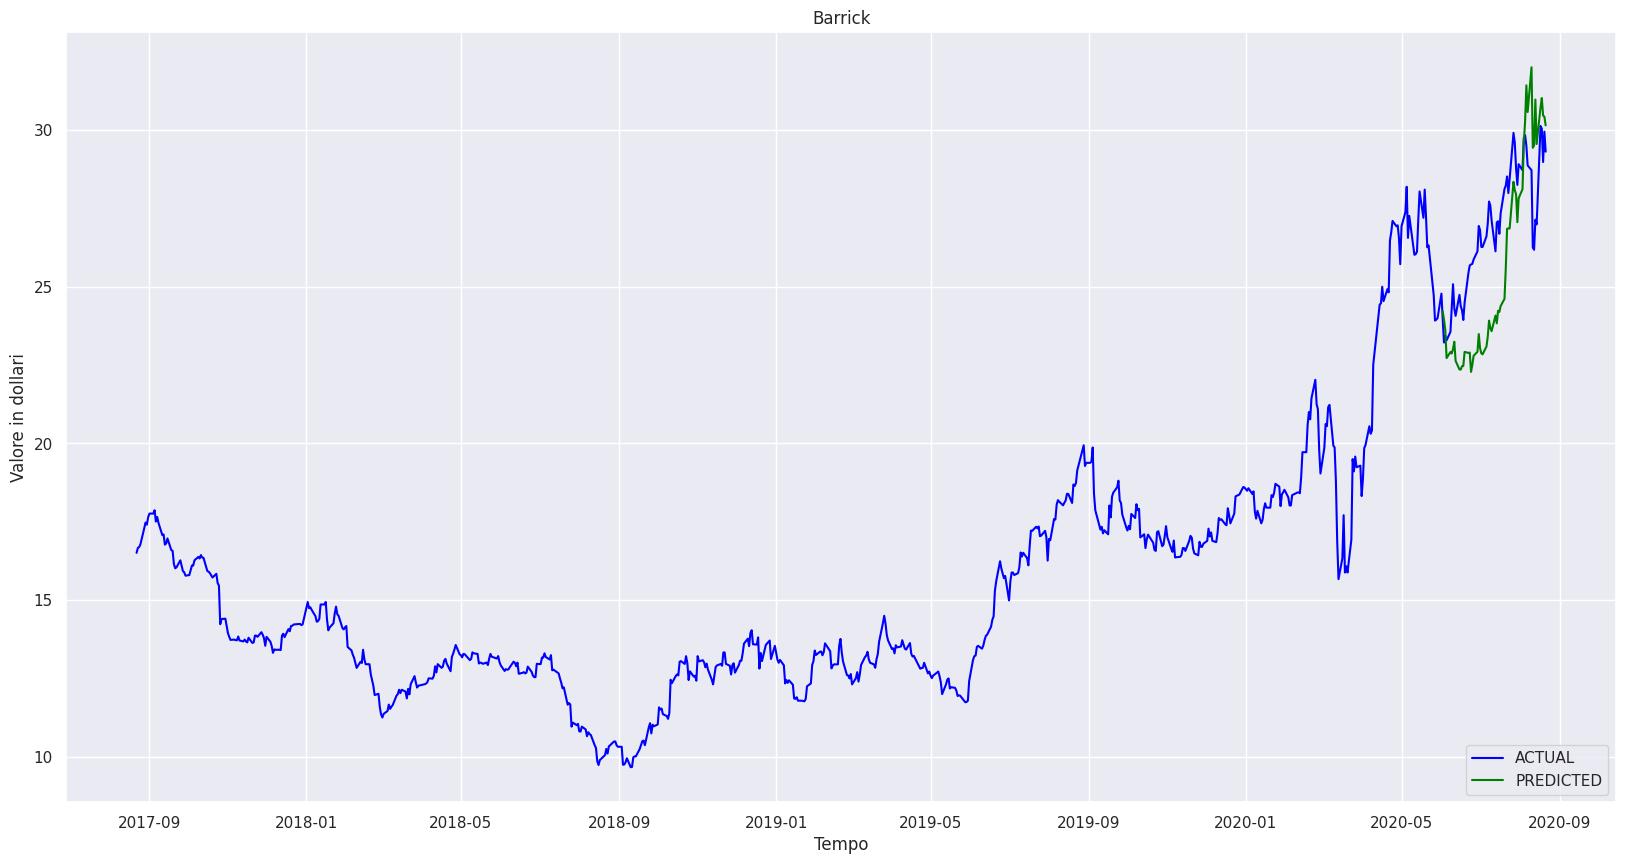

In [54]:
# plot
plt.title('Barrick')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(maindf.index, maindf['BARR'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

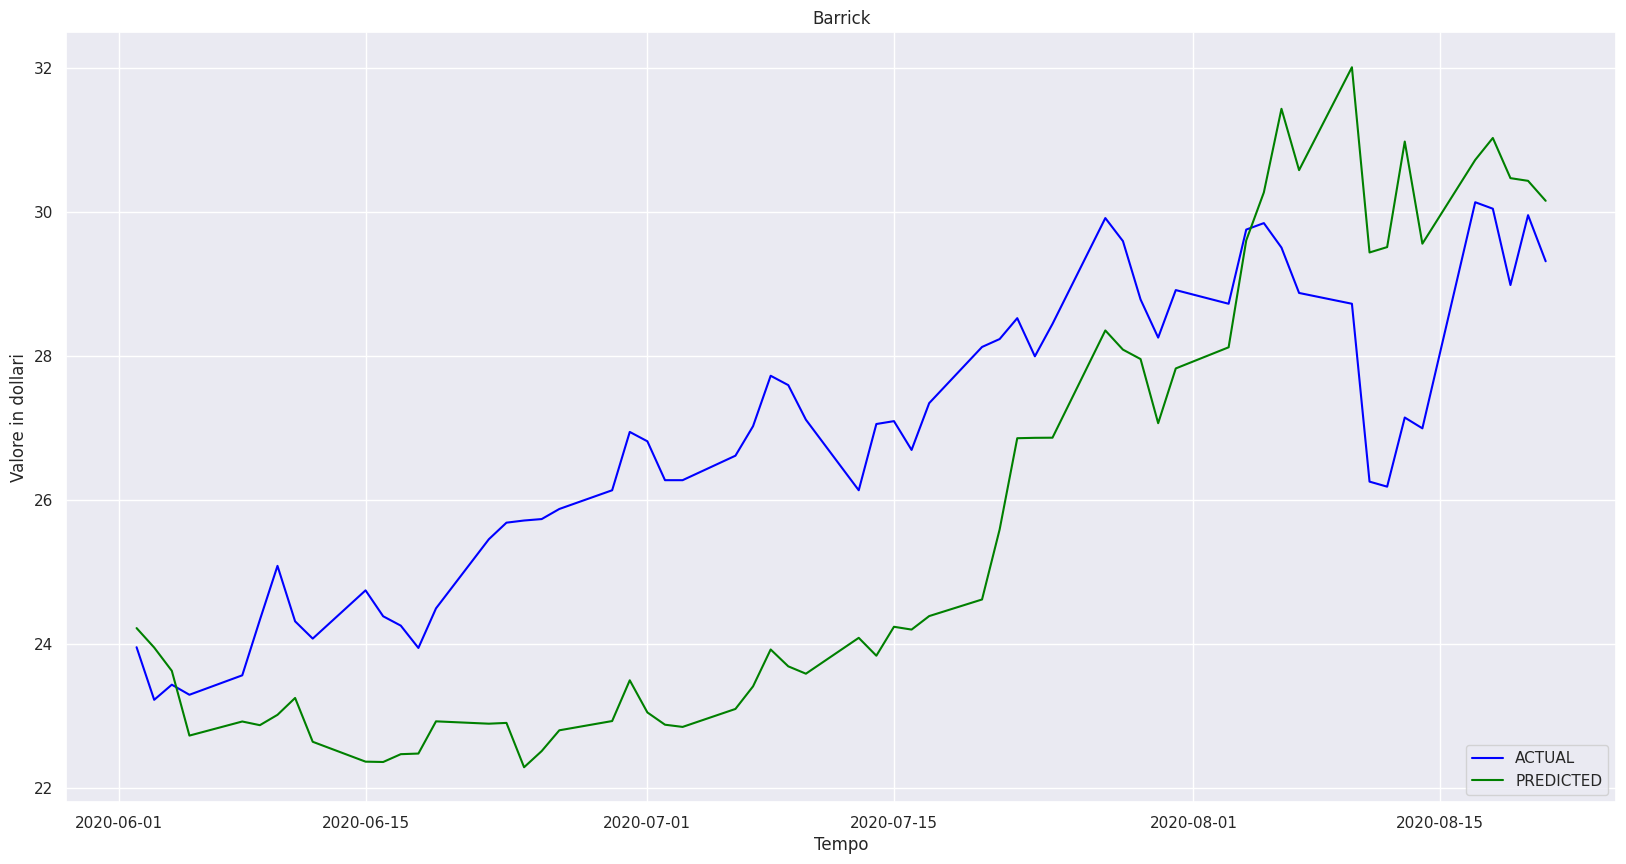

In [55]:
# plot
plt.title('Barrick')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(df_test.index, df_test['BARR'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

### Forecasting Standard&Poors con SARIMAX (GLD, SLV e BARR come variabili esogene)

In [45]:
# Grid Search per vedere quali sono i parametri ottimali
p_values = [0, 1, 2, 3, 4, 5, 6, 7]
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5, 6, 7]

# Variabili endogene
endog_train = df_train['SPX'].values
endog_test = df_test['SPX'].values

# Variabili esogene
exog_train = df_train[['BARR', 'SLV', 'GLD']].values
exog_test = df_test[['BARR', 'SLV', 'GLD']].values

best_RMSE = np.inf
best_params = None

# Ricerca a griglia dei parametri ottimali
for p, d, q in product(p_values, d_values, q_values):
    try:
        model = SARIMAX(endog=endog_train, exog=exog_train, order=(p, d, q))
        fit_model = model.fit()
        predictions = fit_model.forecast(steps=len(endog_test), exog=exog_test)
        RMSE = (mean_squared_error(endog_test, predictions))**0.5

        # Aggiornamento dei parametri ottimali se l'errore attuale è minore del migliore errore
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_params = (p, d, q)

    except:
        continue

print("Parametri ottimali:", best_params)
print("Root Mean Squared Error:", best_RMSE)


Parametri ottimali: (0, 1, 1)
Root Mean Squared Error: 82.19045843439223


In [46]:
order = (0, 1, 1)
model_sarimax = SARIMAX(endog=endog_train, exog=exog_train, order=order)
fit_model = model_sarimax.fit()

predictions = fit_model.forecast(steps= test_dim, exog=exog_test)

rmse = (mean_squared_error(endog_test, predictions))**0.5
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 82.19045843439223


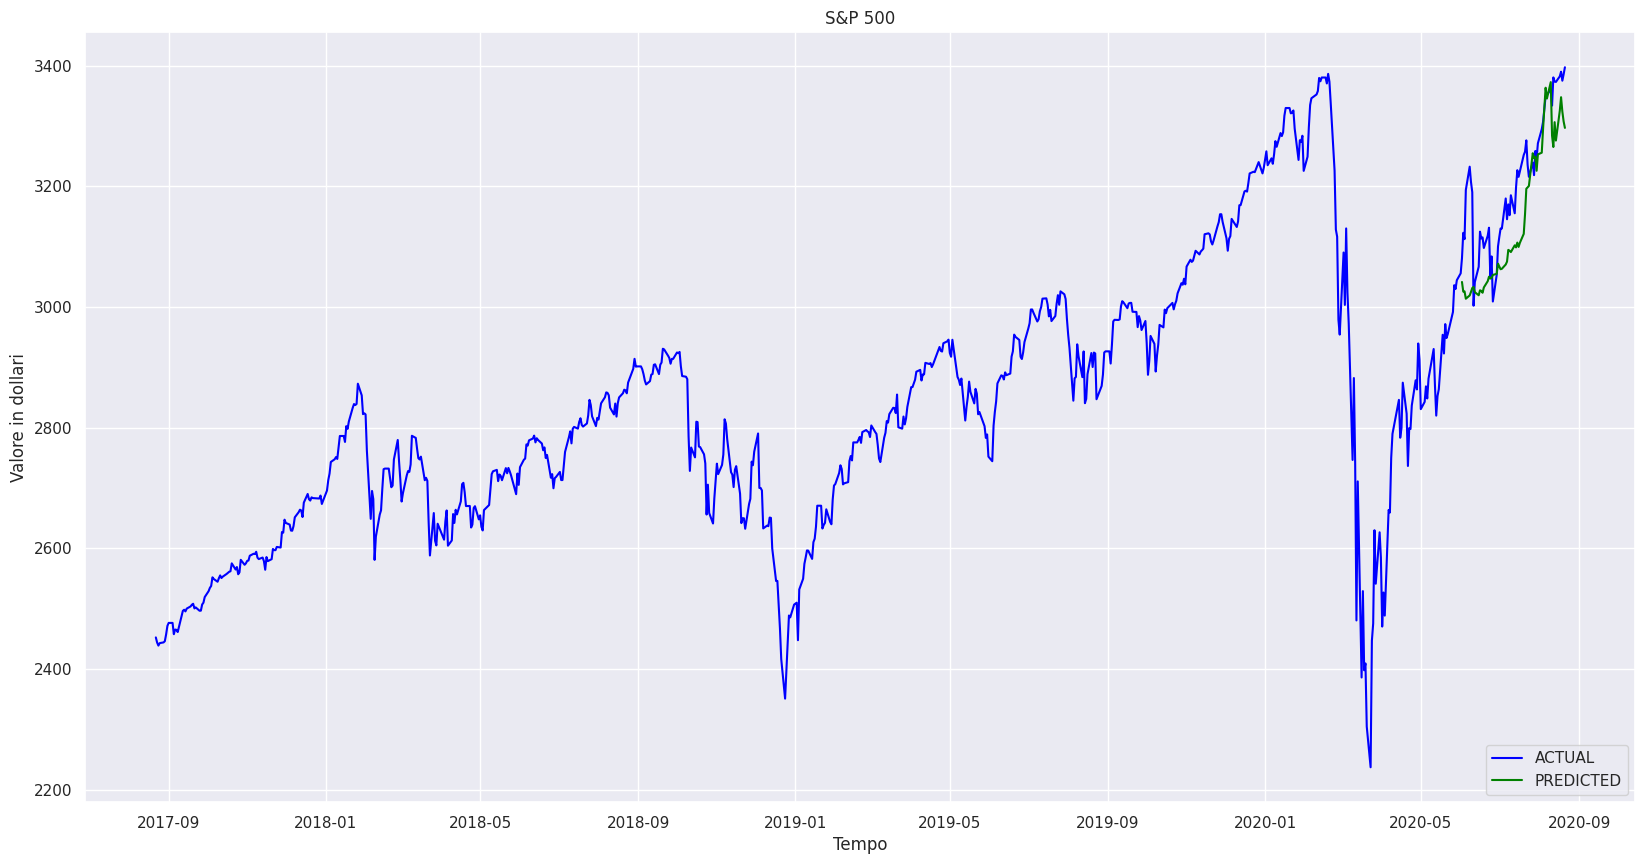

In [47]:
# plot
plt.title('S&P 500')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(maindf.index, maindf['SPX'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

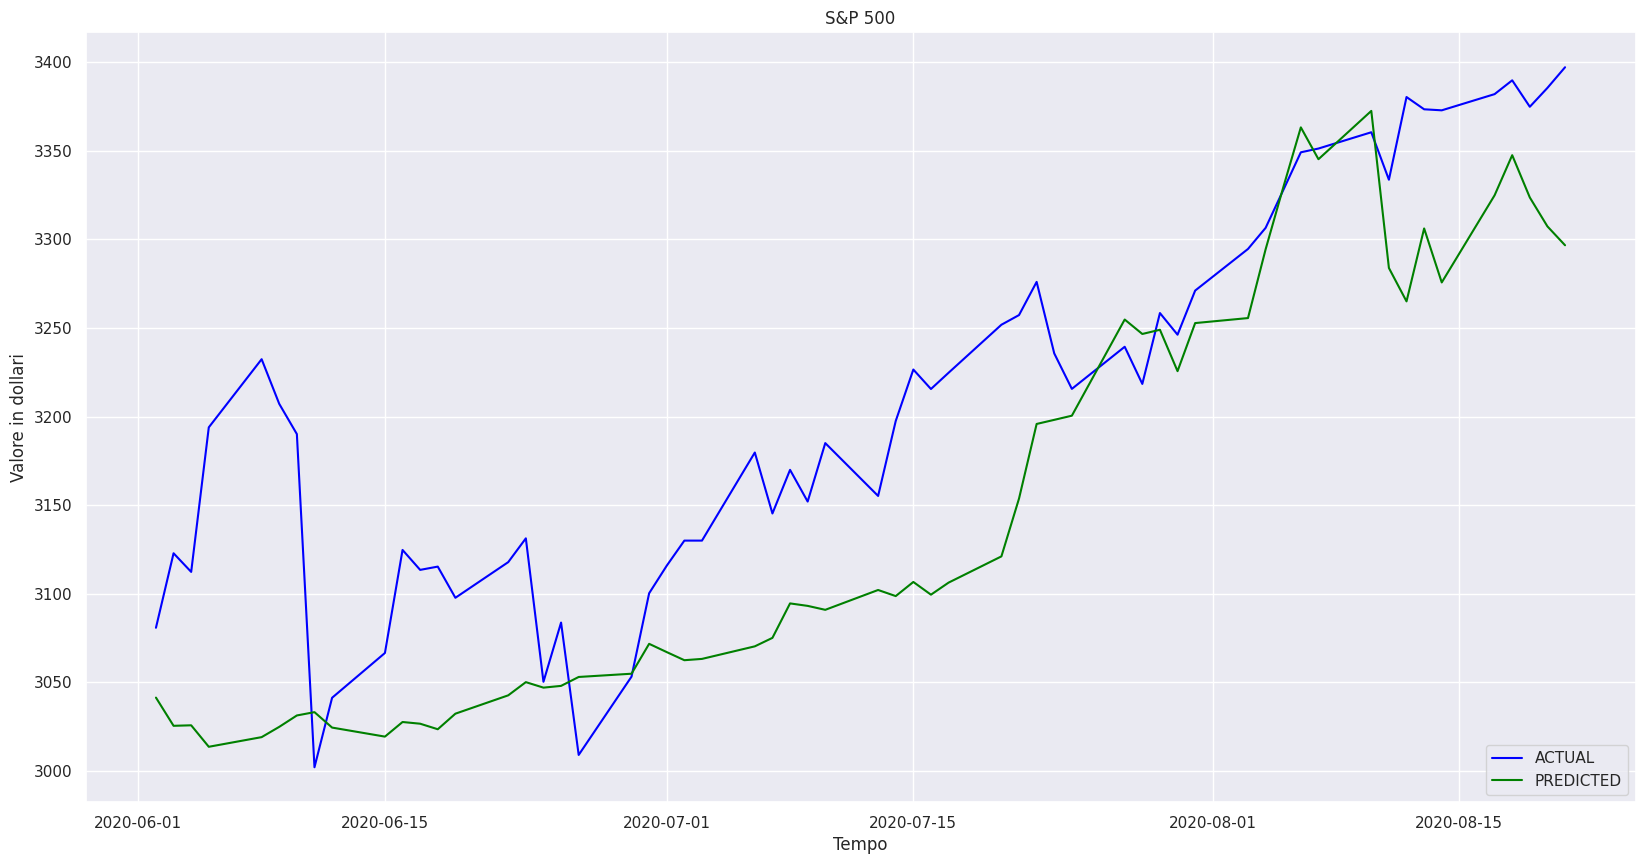

In [48]:
# plot
plt.title('S&P 500')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(df_test.index, df_test['SPX'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()